In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR

from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

from tqdm import tqdm

import numpy as np

import matplotlib.pyplot as plt

In [2]:
dataset_path = './data'

batch_size = 64
input_dim  = 784
hidden_dim = 512
latent_dim = 256

lr = 1e-3

max_lr_decay_factor = 1e-2

epochs = 1000
lr_warmup_epochs = int(epochs * 0.1)
lr_decay_epochs = int(epochs * 0.9)

plot_size = 10

mnist_transform = transforms.Compose([
        transforms.ToTensor()
])

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, drop_last=True)

In [3]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_latent = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc_1(x), negative_slope=0.2)
        x = F.leaky_relu(self.fc_2(x), negative_slope=0.2)
        x = F.leaky_relu(self.fc_latent(x), negative_slope=0.2)
        return x

class Decoder(nn.Module):

    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc_1(x), negative_slope=0.2)
        x = F.leaky_relu(self.fc_2(x), negative_slope=0.2)
        x = torch.sigmoid(self.fc_output(x))
        return x

class Model(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Model, self).__init__()
        self.encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=input_dim)
            
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Model(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)

In [4]:
def update_lr(epoch):
    if epoch < lr_warmup_epochs:
        return epoch / lr_warmup_epochs
    if epoch > lr_decay_epochs:
        return max_lr_decay_factor
    decay_ratio = (epoch - lr_warmup_epochs) / (lr_decay_epochs - lr_warmup_epochs)
    coeff = 0.5 * (1.0 + np.cos(np.pi * decay_ratio))
    return max_lr_decay_factor + coeff * (1 - max_lr_decay_factor)

optimizer = Adam(model.parameters(), lr=lr)
scheduler = LambdaLR(optimizer, update_lr)

In [5]:
model.train()

for epoch in (progress_bar := tqdm(range(epochs))):
    total_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, input_dim)

        optimizer.zero_grad()
    
        x_hat = model(x)
        loss = F.binary_cross_entropy(x_hat, x, reduction="sum")
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()

    scheduler.step()

    progress_bar.set_description(f"Loss: {total_loss / ((batch_idx + 1) * batch_size)}")

Loss: 47.42061788829694: 100%|██████████| 1000/1000 [1:34:41<00:00,  5.68s/it]


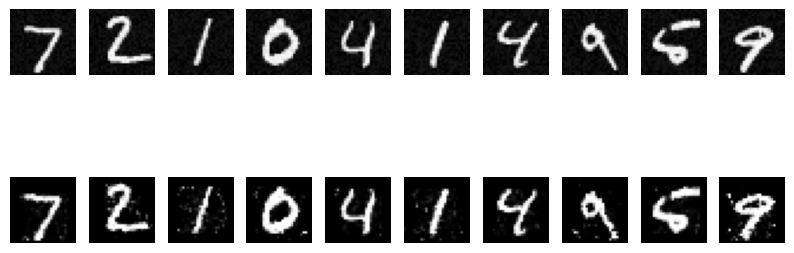

In [8]:
model.eval()

x_reconstructed = []
x_original = []
with torch.no_grad():
    for x, _ in test_loader:
        x = x.view(batch_size, input_dim)
        x = x + 0.1 * torch.rand_like(x)
        x_original.append(x.numpy())
        x_hat = model(x)
        x_reconstructed.append(x_hat.numpy())

x_original = np.concatenate(x_original, axis=0)
x_reconstructed = np.concatenate(x_reconstructed, axis=0)

fig, axes = plt.subplots(nrows=2, ncols=plot_size, figsize=(10, 4))
for idx in range(plot_size):
    axes[0, idx].imshow(x_original[idx].reshape(28, 28), cmap='gray')
    axes[0, idx].axis('off')
    axes[1, idx].imshow(x_reconstructed[idx].reshape(28, 28), cmap='gray')
    axes[1, idx].axis('off')
plt.show()